# Timeseries of all datasets 

This notebook plots the time series of the native means of all assessed datasets.

In [1]:
from pathlib import Path 
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import datetime
import pandas as pd 
import cartopy.crs as ccrs
mpl.style.use("../../ccic.mplstyle")

In [2]:
def get_global_mean(data: xr.DataArray, latname: str, lonname: str):
    """
    Calculate the area-weighted global mean.

    Args:
        data: An xarra.DataArray containing the data of which to compute the mean.
        latname: The name of the latitude coordinate.
        lonname: The neam of the longitude coordinate.

    Rerturn:
        A data array containing the mean.
    """
    weights = np.cos(np.deg2rad(data[latname]))
    weights.name = "weights"
    weighted_data = data.weighted(weights)
    global_mean = weighted_data.mean((lonname, latname))
    return global_mean

In [3]:
data_path = Path('/scratch/ccic_record/data/processed/') 

### ERA5

In [4]:
era5_tiwp = xr.open_dataarray(data_path / 'era5_tiwp_global_mean_timeseries.nc')
era5_ca = xr.open_dataarray(data_path / 'era5_ca_global_mean_timeseries.nc')

### ISCCP

In [5]:
isccp = xr.open_dataset(data_path / 'isccp_tiwp_ca.nc')
isccp_ca = isccp.ca_avg_masked
isccp_tiwp = isccp.tiwp_avg_masked

### CCIC (GridSat)

In [6]:
ccic_gridsat = xr.open_dataset(data_path / 'ccic_gridsat.nc')
ccic_gridsat_tiwp = ccic_gridsat.tiwp_mean_masked
ccic_ca = ccic_gridsat.ca_mean_masked
start = datetime.datetime(1980, 1, 1, 0, 0)
end = datetime.datetime(2022, 12, 31, 0, 23)
ccic_times = pd.date_range(start, end, freq= '1ME')

### PATMOS-x

In [7]:
patmosx = xr.open_dataset(data_path / ".." / 'PATMOS-x_timeseries198108-202106_notebook_results.nc')
patmosx_tiwp = patmosx.tiwp_typeIIaverage_masked
patmosx_ca = patmosx.cloud_probability_typeIaverage_masked

### MODIS

In [8]:
modis = xr.open_dataset(data_path / 'modis_cf_tiwp_time_series.nc')
modis_tiwp = modis.TIWP_global_mean_masked
modis_ca = modis.CF_global_mean_masked
modis_times = modis.date

### CloudSat

In [37]:
cloudsat = xr.open_dataset(data_path / "cloudsat_time_series.nc") 
dardar_timeseries = cloudsat.tiwp_masked_mean_dardar
twocice_timeseries = cloudsat.tiwp_masked_mean_2cice
cloudsat_times = cloudsat.time

### GridSat (CPCIR)

In [38]:
cpcir = xr.open_dataset('/scratch/ccic_record/data/ccic/cpcir/ccic_cpcir_1998-2023_monthlymeans.nc')
cpcir_timeseries = cpcir.tiwp_mean 
cpcir_times = cpcir.time

## Global means of Cloud amount and ice water path 

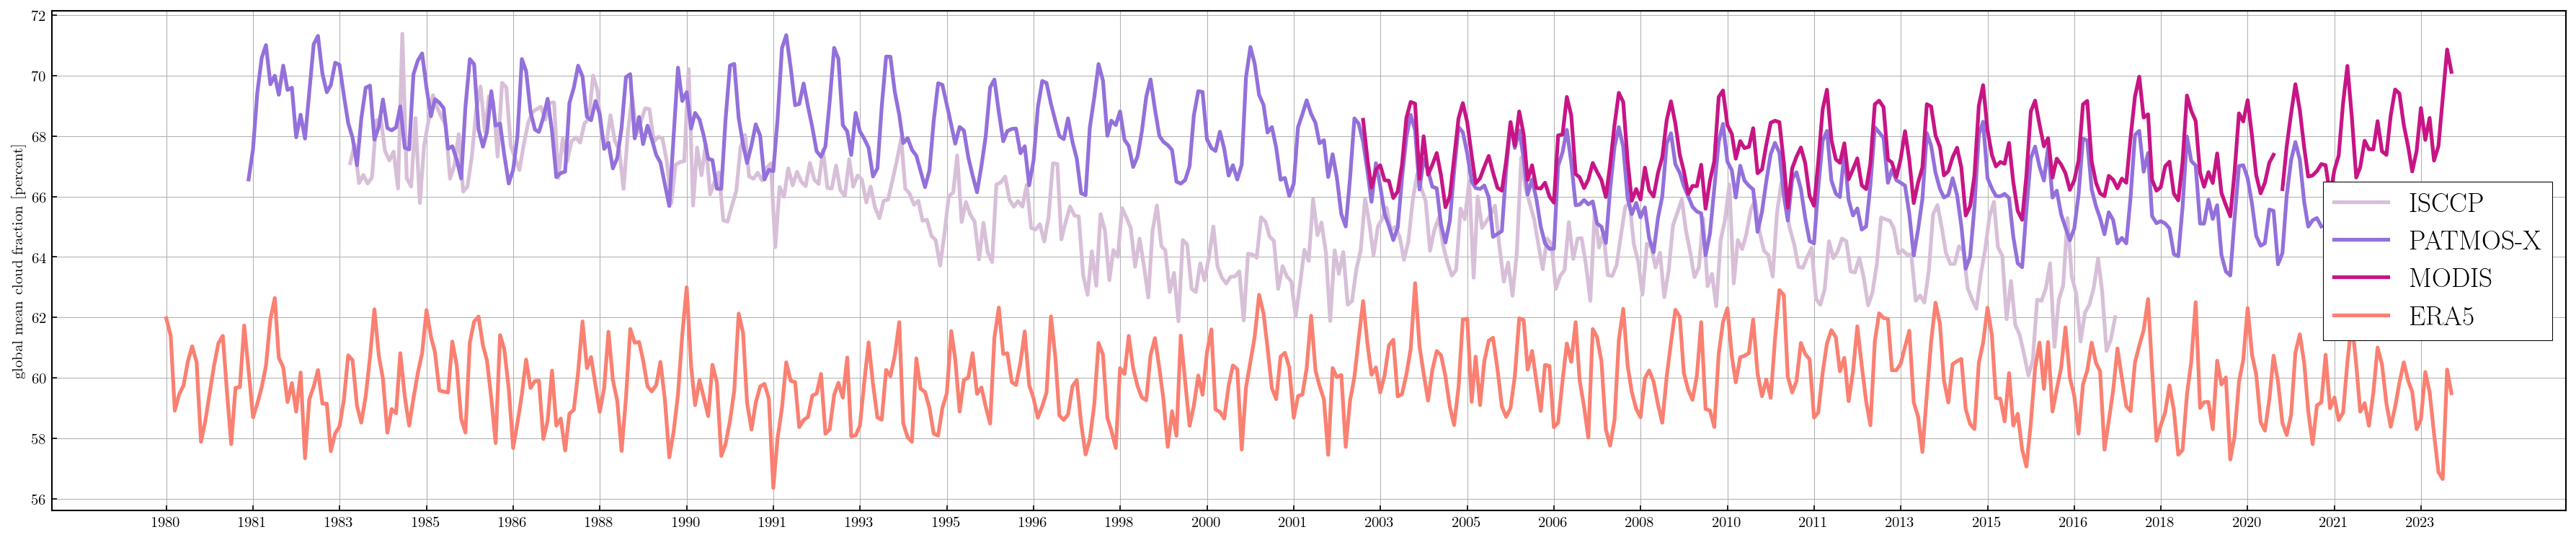

In [39]:
plt.figure(figsize=(30,6))

lw = 2.5

# monthly timeseries cloud amount 
plt.subplot(1,1,1)
plt.plot(isccp_ca.time, isccp_ca.data, label = 'ISCCP', lw = lw, color = 'thistle')
plt.plot(patmosx_ca.time, patmosx_ca.data* 100, label = 'PATMOS-X', lw = lw, color = 'mediumpurple') 
plt.plot(modis_times, modis_ca* 100, lw = lw ,label = 'MODIS' , color = 'mediumvioletred')
plt.plot(era5_ca.time, era5_ca.data* 100 , label = 'ERA5', lw = lw, color = 'salmon')

plt.ylabel(r'global mean cloud fraction [percent]')
plt.xticks(era5_ca.time[::20], era5_ca.time.dt.year.values[::20])
plt.grid()
plt.legend(fontsize = 18)
plt.savefig('global_mean_cloud_fraction_timeseries.png', bbox_inches = 'tight')
plt.show()

# Global means of ice water path 

In [34]:
import cmocean
from matplotlib.colors import to_rgba
import seaborn as sns
sns.reset_orig()
c0 = sns.desaturate(to_rgba("#f5316c"), 0.4)

In [43]:
%pwd

'/home/spfrnd/src/ccic_climate_record_analysis/notebooks/analysis'

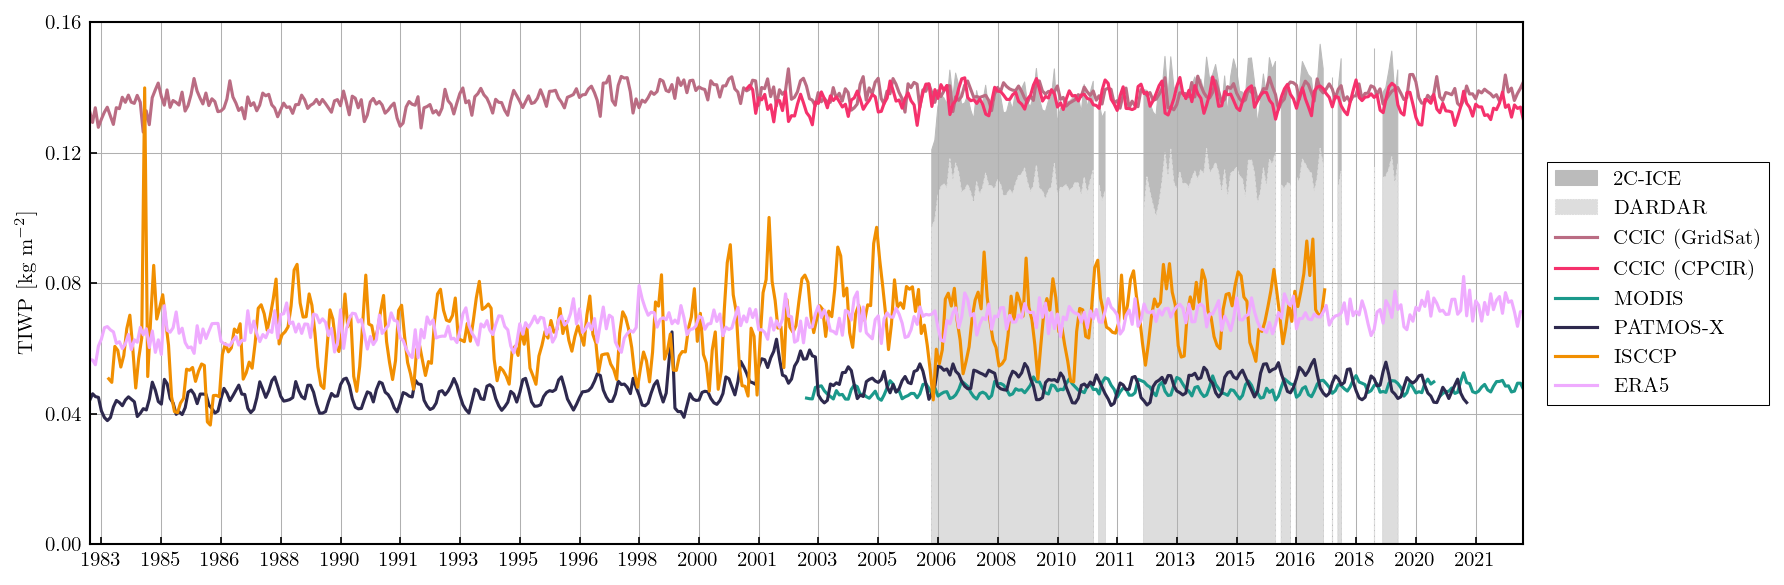

In [44]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12,4))
gs = GridSpec(1, 2, width_ratios=[1.0, 0.01])

ax = fig.add_subplot(gs[0, 0])
lw = None

handles = []
handles += ax.plot(ccic_times[24:], ccic_gridsat_tiwp.data[24:], label = 'CCIC (GridSat)', lw = lw, c=c0)
handles += ax.plot(cpcir.time[24:], cpcir_timeseries[24:], lw = lw, label= 'CCIC (CPCIR)', c="C0")
handles += ax.plot(modis_times, modis_tiwp/1000, label = 'MODIS',lw = lw, c="C1")
handles += ax.plot(patmosx_tiwp.time, patmosx_tiwp.data/1000, label = 'PATMOS-X' , lw = lw, c="C2")
handles += ax.plot(isccp_tiwp.time, isccp_tiwp.data, label = 'ISCCP',  lw = lw, c="C3") 
handles += ax.plot(era5_tiwp.time, era5_tiwp.data, label = 'ERA5',  lw = lw, c="C4")


# add CloudSat and CPCIR 
h2c = ax.fill_between(cloudsat.time, 0, twocice_timeseries.where(twocice_timeseries > 0  ), lw = lw, label = '2C-ICE', color = '#bbbbbb')
hdd = ax.fill_between(cloudsat.time, 0, dardar_timeseries.where(dardar_timeseries > 0   ), lw =lw, label = 'DARDAR',  color = '#dddddd',linestyle ='--')

handles = [h2c, hdd] + handles

ax.set_ylabel(r'TIWP [kg m$^{-2}]$')
ax.set_xticks(era5_tiwp.time[::20], era5_tiwp.time.dt.year.values[::20])
ax.set_yticks(np.arange(0., 0.18, 0.04))
ax.grid()
ax.set_ylim(0, 0.16)
ax.set_xlim(np.datetime64("1983-01-01"), np.datetime64("2023-01-01"))

ax = fig.add_subplot(gs[0, 1])
ax.set_axis_off()
ax.legend(handles=handles, loc="center")

plt.tight_layout()
plt.savefig('../../figures/tiwp_time_series.pdf', bbox_inches = 'tight')
plt.show()

In [33]:
import seaborn as sns
sns.reset_orig()
c0 = sns.desaturate(to_rgba("#f5316c"), 0.4)

plt.figure(figsize=(34,12))

fs = 28
lw = 3.5
# monthly timeseries ice water path 
plt.subplot(1,1,1)
plt.plot(ccic_times[24:], ccic_tiwp.data[24:], label = 'CCIC (GridSat)', lw = lw, c="C0")
plt.plot(cpcir.time[24:], cpcir_timeseries[24:], lw = lw, label= 'CCIC (CPCIR)', c=c0)
plt.plot(modis_times, modis_tiwp/1000, label = 'MODIS',lw = lw, c="C1")
plt.plot(patmosx_tiwp.time, patmosx_tiwp.data/1000, label = 'PATMOS-X' , lw = lw, c="C2")
plt.plot(isccp_tiwp.time, isccp_tiwp.data, label = 'ISCCP',  lw = lw, c="C3")
plt.plot(era5_tiwp.time, era5_tiwp.data, label = 'ERA5',  lw = lw, c="C4")


# add CloudSat and CPCIR 
plt.plot(cloudsat.time, dardar_timeseries.where(dardar_timeseries > 0   ), lw =lw, label = 'DARDAR',  color = 'k',linestyle ='--')
plt.plot(cloudsat.time, twocice_timeseries.where(twocice_timeseries > 0  ), lw = lw, label = '2C-ICE', color = 'k')

plt.ylabel(r'tiwp [kg m$^{-2}]$', fontsize = fs)
plt.xticks(era5_tiwp.time[::20], era5_tiwp.time.dt.year.values[::20], fontsize = fs)
plt.yticks(np.arange(0., 0.18, 0.04), fontsize = fs)
plt.grid()
plt.legend(fontsize= fs, loc = 'lower left')

plt.tight_layout()
plt.savefig('/scratch/ccic_record/data/plots/tiwp_timeseries_ccicstyle.png', bbox_inches = 'tight')
plt.show()

NameError: name 'to_rgba' is not defined

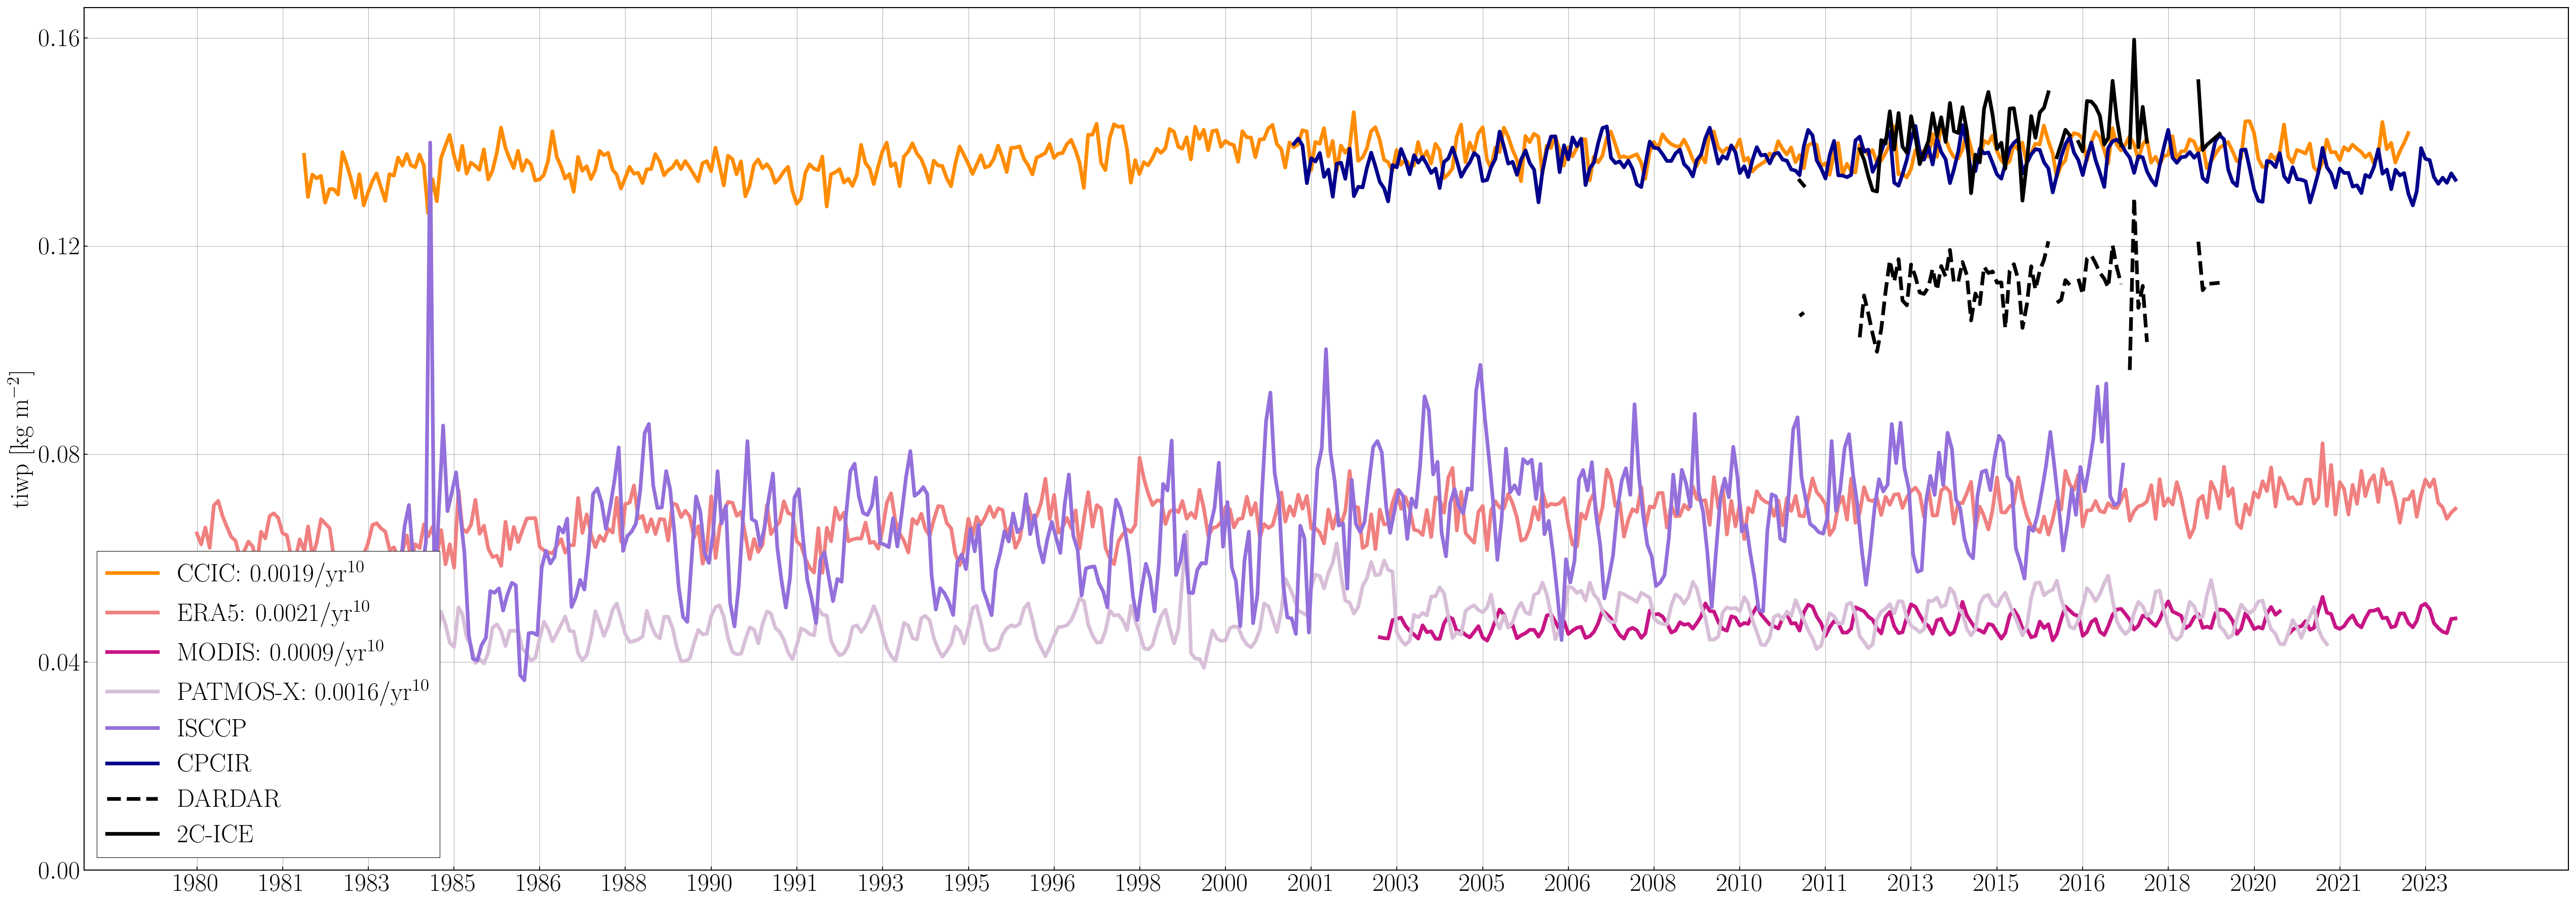

In [72]:
plt.figure(figsize=(34,12))

fs = 24
lw = 3.5
# monthly timeseries ice water path 
plt.subplot(1,1,1)
plt.plot(ccic_times[24:], ccic_tiwp.data[24:], label = ('CCIC: ' + str(np.round(slope_ccic*10, decimals = 4)) + '/yr$^{10}$'), color = 'darkorange', lw = lw)
plt.plot(era5_tiwp.time, era5_tiwp.data, label = ('ERA5: ' + str(np.round(slope_era*10, decimals = 4))+  '/yr$^{10}$'), color = 'lightcoral', lw = lw)
plt.plot(modis_times, modis_tiwp/1000, label = ('MODIS: ' + str(np.round(slope_modis*10, decimals = 4))+  '/yr$^{10}$'), color = 'mediumvioletred', lw = lw)
plt.plot(patmosx_tiwp.time, patmosx_tiwp.data/1000, label = ('PATMOS-X: ' + str(np.round(slope_patmosx*10, decimals = 4)) +  '/yr$^{10}$') , color = 'thistle', lw = lw)
plt.plot(isccp_tiwp.time, isccp_tiwp.data, label = 'ISCCP', color = 'mediumpurple', lw = lw) 
plt.plot(cpcir.time[24:], cpcir_timeseries[24:], lw = lw, label= 'CPCIR', color = 'darkblue')

# add CloudSat and CPCIR 
plt.plot(cloudsat.time, dardar_timeseries.where(dardar_timeseries > 0   ), lw =lw, label = 'DARDAR', color= 'k', linestyle ='--')
plt.plot(cloudsat.time, twocice_timeseries.where(twocice_timeseries > 0  ), lw = lw, label = '2C-ICE', color = 'k')

plt.ylabel(r'tiwp [kg m$^{-2}]$', fontsize = fs)
plt.xticks(era5_tiwp.time[::20], era5_tiwp.time.dt.year.values[::20], fontsize = fs)
plt.yticks(np.arange(0., 0.18, 0.04), fontsize = fs)
plt.grid()
plt.legend(fontsize= fs, loc = 'lower left')

plt.tight_layout()
plt.savefig('/scratch/ccic_record/tiwp_timeseries.pdf', bbox_inches = 'tight')
plt.show()

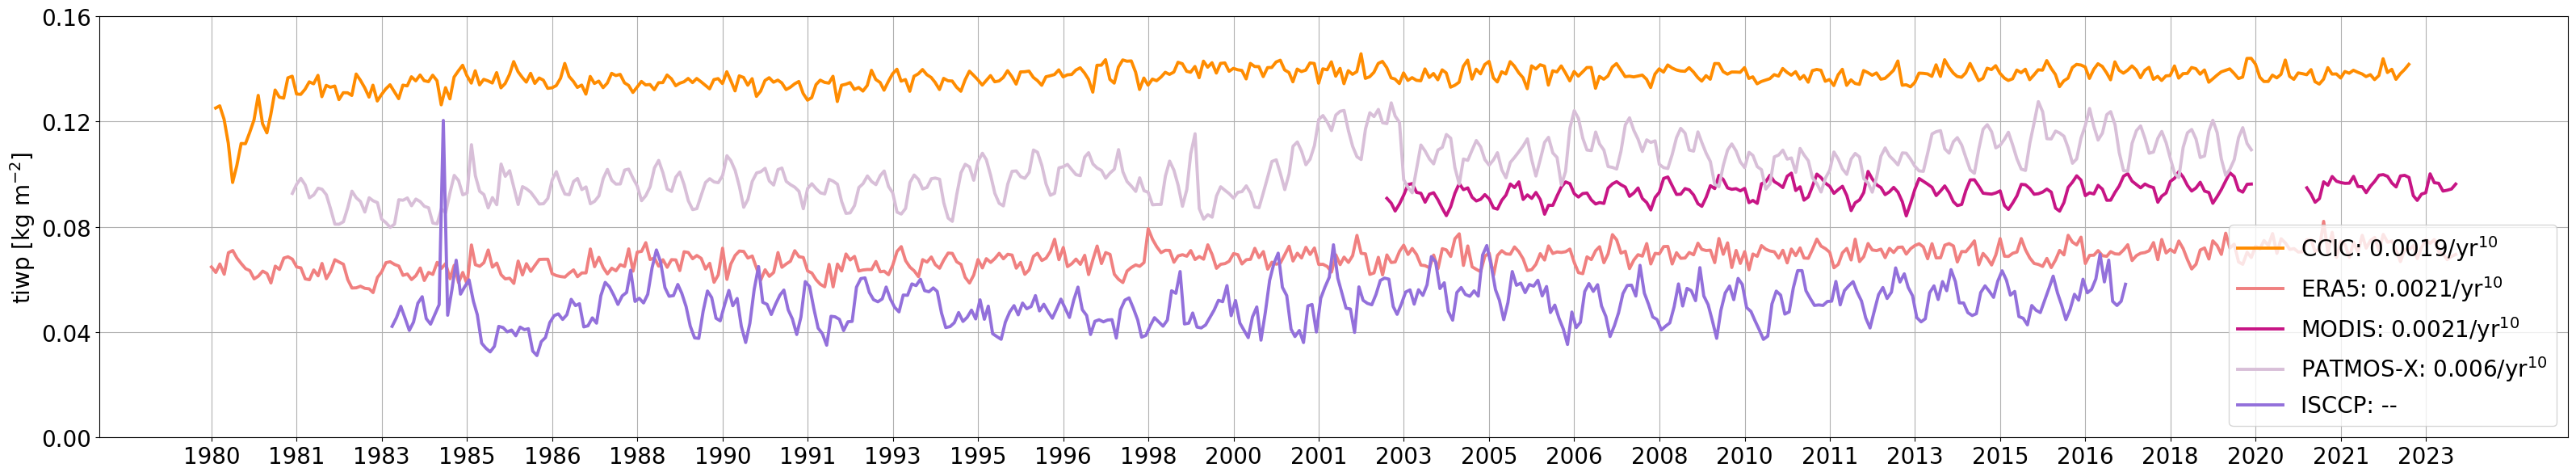

In [16]:
plt.figure(figsize=(32,6))

fs = 20
lw = 2.8
# monthly timeseries ice water path 
plt.subplot(1,1,1)
plt.plot(ccic_times, ccic_tiwp.data, label = ('CCIC: ' + str(np.round(slope_ccic*10, decimals = 4)) + '/yr$^{10}$'), color = 'darkorange', lw = lw)
plt.plot(era5_tiwp.time, era5_tiwp.data, label = ('ERA5: ' + str(np.round(slope_era*10, decimals = 4))+  '/yr$^{10}$'), color = 'lightcoral', lw = lw)
plt.plot(modis_times, modis_tiwp/1000, label = ('MODIS: ' + str(np.round(slope_modis*10, decimals = 4))+  '/yr$^{10}$'), color = 'mediumvioletred', lw = lw)
plt.plot(patmosx_tiwp.time, patmosx_tiwp.data/1000, label = ('PATMOS-X: ' + str(np.round(slope_patmosx*10, decimals = 4)) +  '/yr$^{10}$') , color = 'thistle', lw = lw)
plt.plot(isccp_tiwp.time, isccp_tiwp.data, label = 'ISCCP: --', color = 'mediumpurple', lw = lw) 

plt.ylabel(r'tiwp [kg m$^{-2}]$', fontsize = fs)
plt.xticks(era5_tiwp.time[::20], era5_tiwp.time.dt.year.values[::20], fontsize = fs)
plt.yticks(np.arange(0., 0.18, 0.04), fontsize = fs)
plt.grid()
plt.legend(fontsize= fs)

plt.tight_layout()
plt.savefig('/scratch/ccic_record/data/plots/tiwp_timeseries.png', bbox_inches = 'tight')
plt.show()

## Split up by ocean vs. land 

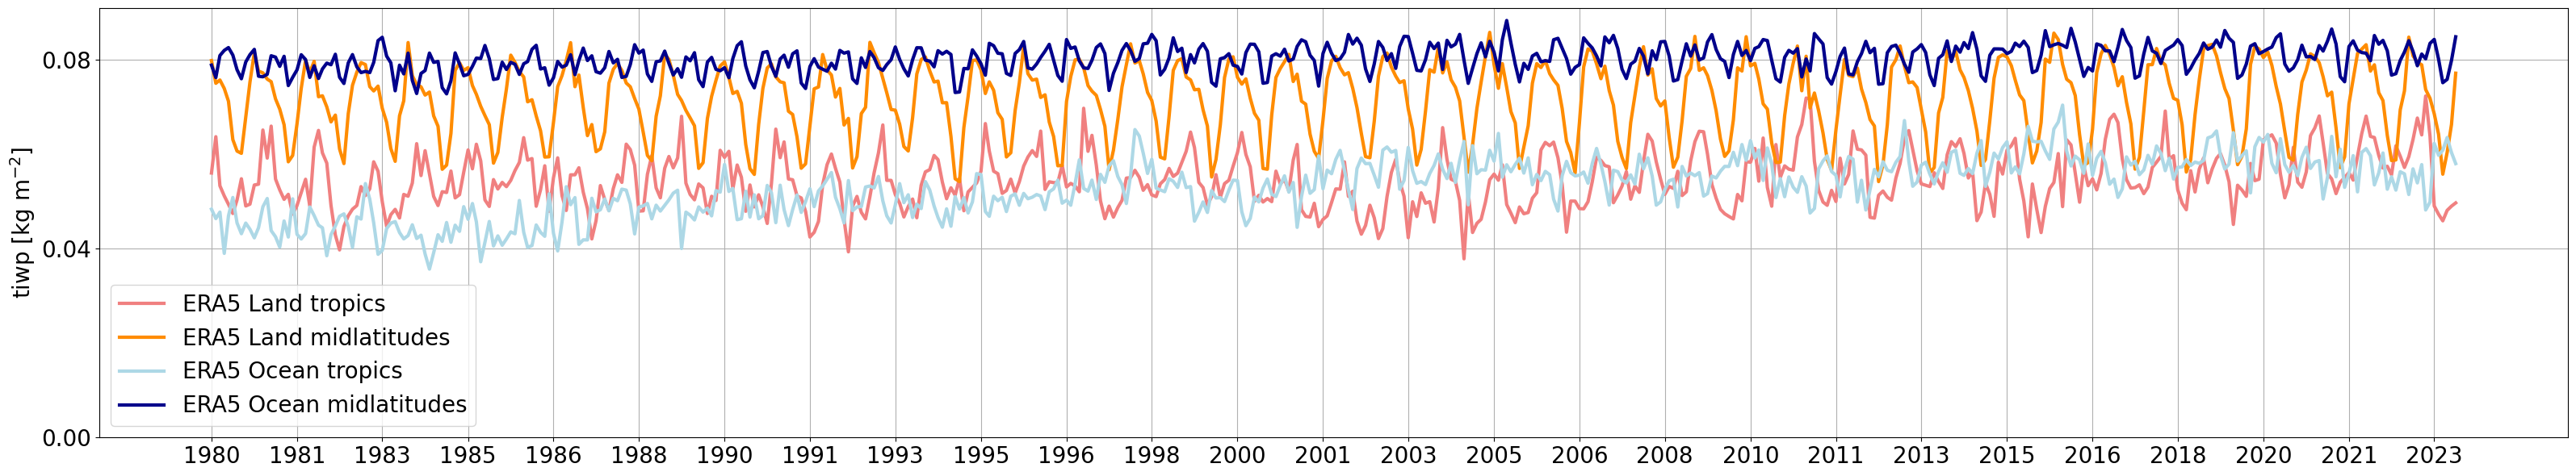

In [92]:
plt.figure(figsize=(32,6))

fs = 20
lw = 3.0 

# monthly timeseries ice water path 
plt.subplot(1,1,1)
plt.plot(era5.time, era_land_tropics, label = 'ERA5 Land tropics', color = 'lightcoral', lw = lw)
plt.plot(era5.time, era_land_midlats, label = 'ERA5 Land midlatitudes', color = 'darkorange', lw = lw)
plt.plot(era5.time, era_ocean_tropics, label = 'ERA5 Ocean tropics', color = 'lightblue', lw = lw)
plt.plot(era5.time, era_ocean_midlats, label = 'ERA5 Ocean midlatitudes', color = 'darkblue', lw = lw) 

plt.ylabel(r'tiwp [kg m$^{-2}]$', fontsize = fs)
plt.xticks(era5_tiwp.time[::20], era5_tiwp.time.dt.year.values[::20], fontsize = fs)
plt.yticks(np.arange(0., 0.12, 0.04), fontsize = fs)
plt.grid()
plt.legend(fontsize= fs)

plt.tight_layout()
plt.savefig('/scratch/ccic_record/data/plots/ERA5_timeseries_land_ocean.png', bbox_inches = 'tight')
plt.show()

## Difference cloud fraction [in %] ISCCP - CCIC 

In [4]:
# interpolate CCIC to ISCCP grid 
ccic_isccp_grid = ccic.ca.interp(coords = {'longitude': isccp.longitude.values, 'latitude': isccp.latitude.values}, method = 'linear')
ccic_timmean = ccic_isccp_grid * 100 
isccp_timmean = isccp.ca
diff= isccp_timmean - ccic_timmean 

In [5]:
import seaborn as sns 
cmap_sns= sns.color_palette("vlag", as_cmap=True)

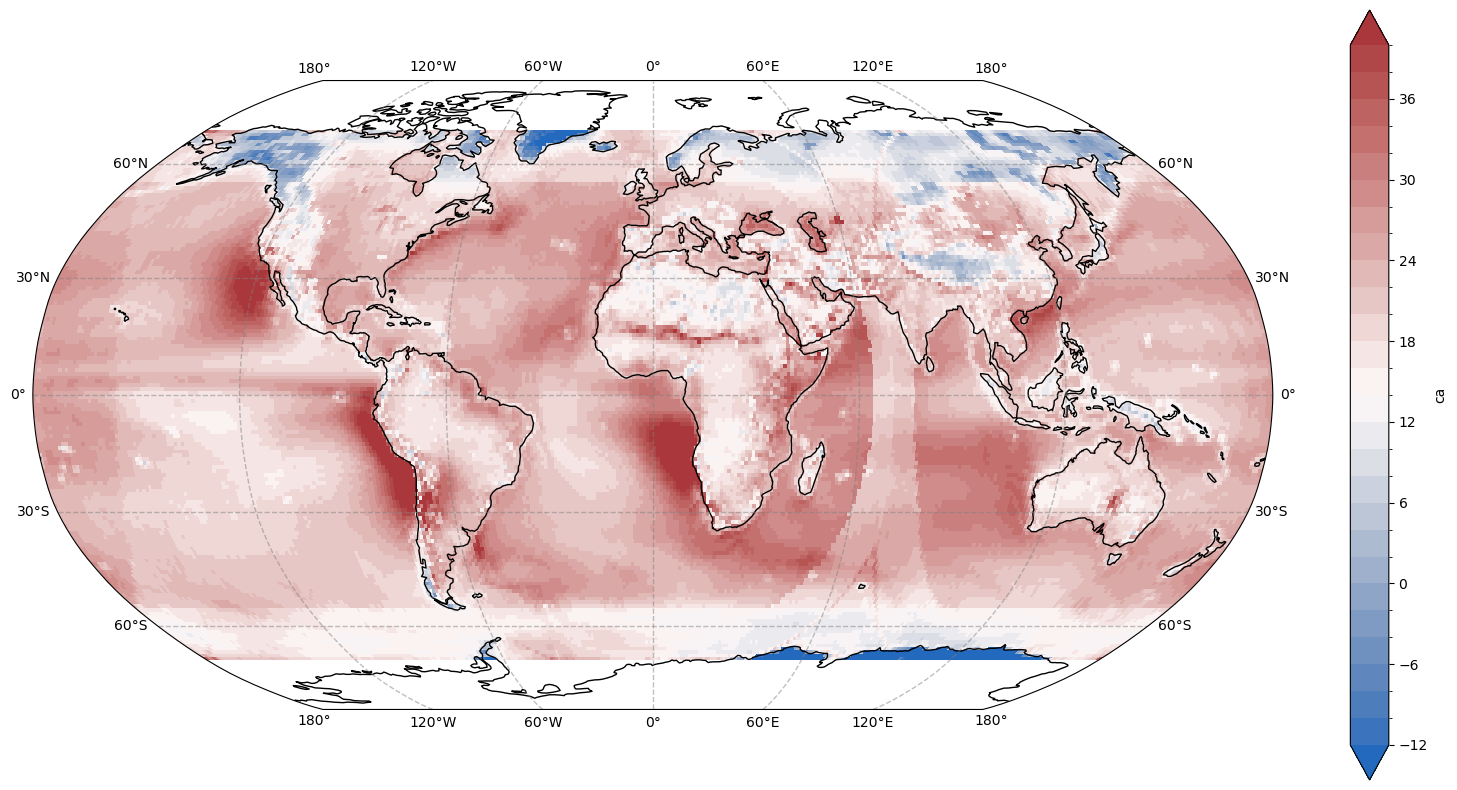

In [6]:
plt.figure(figsize=(20,10))

ax = plt.axes(projection=ccrs.Robinson())
diff.plot(
    ax=ax, 
    levels = np.arange(-12,42, 2),
    transform=ccrs.PlateCarree(),
    colors=cmap_sns)

ax.coastlines(
    resolution='110m') 
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  draw_labels=True,
                  linewidth=1,
                  color='gray',
                  alpha=0.5,
                  linestyle='--')

plt.savefig('diff_map_isscp_minus_ccic.png', bbox_inches = 'tight')